# 🚑 AmbuRoute - Data Collection & Preprocessing
## Phase 2: Dataset Preparation for Ambulance Detection

This notebook handles data collection, preprocessing, and preparation for training the ambulance detection model.


## 📊 Dataset Overview

For the AmbuRoute project, we need to collect and prepare data for:
- **Ambulance Detection**: Images and videos containing ambulances
- **Traffic Scenes**: CCTV footage from traffic cameras
- **Annotation**: Bounding box labels for ambulance detection

### Data Sources:
1. **Public Datasets**: COCO, Open Images, custom traffic datasets
2. **Web Scraping**: Traffic camera feeds, emergency vehicle images
3. **Synthetic Data**: Generated ambulance images using data augmentation
4. **Real-world Collection**: Traffic intersection footage


In [1]:
# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import requests
import zipfile
import json
import yaml
from tqdm import tqdm
import random
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📦 Data Collection & Preprocessing Environment Ready!")
print("🔧 Libraries imported successfully")


📦 Data Collection & Preprocessing Environment Ready!
🔧 Libraries imported successfully


In [2]:
pip install albumentations

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Replace the albumentations import and usage with:
import cv2
import numpy as np

# Replace the DataAugmentationPipeline class with OpenCV-based augmentation
class DataAugmentationPipeline:
    def __init__(self):
        self.augmentations = [
            self.horizontal_flip,
            self.rotation,
            self.brightness_contrast,
            self.noise,
            self.blur
        ]
    
    def horizontal_flip(self, image, label):
        if np.random.random() > 0.5:
            image = cv2.flip(image, 1)
            # Update bounding box coordinates accordingly
        return image, label
    
    def rotation(self, image, label):
        angle = np.random.uniform(-15, 15)
        h, w = image.shape[:2]
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
        image = cv2.warpAffine(image, M, (w, h))
        return image, label
    
    def brightness_contrast(self, image, label):
        alpha = np.random.uniform(0.8, 1.2)  # Contrast
        beta = np.random.uniform(-30, 30)    # Brightness
        image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
        return image, label
    
    def noise(self, image, label):
        noise = np.random.normal(0, 25, image.shape).astype(np.uint8)
        image = cv2.add(image, noise)
        return image, label
    
    def blur(self, image, label):
        if np.random.random() > 0.7:
            kernel_size = np.random.choice([3, 5])
            image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
        return image, label

## 🗂️ Dataset Collection Class


In [4]:
class AmbulanceDataCollector:
    """Comprehensive data collection and preprocessing class for ambulance detection"""
    
    def __init__(self, project_root="."):
        self.project_root = Path(project_root)
        self.dataset_path = self.project_root / "dataset"
        self.images_path = self.dataset_path / "images"
        self.labels_path = self.dataset_path / "labels"
        self.raw_videos_path = self.dataset_path / "raw_videos"
        
        # Create necessary directories
        self._create_directories()
        
        # Dataset statistics
        self.stats = {
            'total_images': 0,
            'ambulance_images': 0,
            'traffic_images': 0,
            'annotations': 0
        }
    
    def _create_directories(self):
        """Create necessary directory structure"""
        directories = [
            self.dataset_path,
            self.images_path / "train",
            self.images_path / "val", 
            self.images_path / "test",
            self.labels_path / "train",
            self.labels_path / "val",
            self.labels_path / "test",
            self.raw_videos_path
        ]
        
        for directory in directories:
            directory.mkdir(parents=True, exist_ok=True)
            print(f"✅ Created directory: {directory}")
    
    def download_sample_dataset(self):
        """Download sample datasets for demonstration"""
        print("📥 Downloading sample datasets...")
        
        # Sample dataset URLs (you can replace with actual datasets)
        sample_datasets = {
            'coco_vehicles': 'https://images.cocodataset.org/zips/val2017.zip',
            'traffic_videos': 'https://example.com/traffic_videos.zip'  # Replace with actual URL
        }
        
        # For demonstration, we'll create synthetic data
        print("🔄 Creating synthetic dataset for demonstration...")
        self._create_synthetic_dataset()
    
    def _create_synthetic_dataset(self):
        """Create synthetic ambulance and traffic images for demonstration"""
        print("🎨 Generating synthetic dataset...")
        
        # Create synthetic ambulance images
        self._generate_ambulance_images(50)
        
        # Create synthetic traffic images
        self._generate_traffic_images(100)
        
        print("✅ Synthetic dataset created successfully!")
    
    def _generate_ambulance_images(self, num_images):
        """Generate synthetic ambulance images"""
        for i in tqdm(range(num_images), desc="Generating ambulance images"):
            # Create a random background
            img = np.random.randint(0, 255, (640, 640, 3), dtype=np.uint8)
            
            # Add some random shapes to simulate traffic scene
            cv2.rectangle(img, (50, 50), (590, 590), (100, 100, 100), -1)  # Road
            cv2.rectangle(img, (100, 100), (540, 200), (200, 200, 200), -1)  # Sidewalk
            
            # Add ambulance-like shape
            ambulance_x = random.randint(100, 400)
            ambulance_y = random.randint(300, 500)
            cv2.rectangle(img, (ambulance_x, ambulance_y), 
                         (ambulance_x + 120, ambulance_y + 60), (255, 255, 255), -1)
            cv2.rectangle(img, (ambulance_x + 10, ambulance_y + 10), 
                         (ambulance_x + 110, ambulance_y + 50), (255, 0, 0), -1)
            
            # Add cross (ambulance symbol)
            cv2.line(img, (ambulance_x + 60, ambulance_y + 20), 
                    (ambulance_x + 60, ambulance_y + 40), (255, 255, 255), 3)
            cv2.line(img, (ambulance_x + 50, ambulance_y + 30), 
                    (ambulance_x + 70, ambulance_y + 30), (255, 255, 255), 3)
            
            # Save image
            img_path = self.images_path / "train" / f"ambulance_{i:04d}.jpg"
            cv2.imwrite(str(img_path), img)
            
            # Create corresponding label file
            self._create_yolo_label(img_path, ambulance_x, ambulance_y, 120, 60)
            
            self.stats['ambulance_images'] += 1
    
    def _generate_traffic_images(self, num_images):
        """Generate synthetic traffic images without ambulances"""
        for i in tqdm(range(num_images), desc="Generating traffic images"):
            # Create a random background
            img = np.random.randint(0, 255, (640, 640, 3), dtype=np.uint8)
            
            # Add some random shapes to simulate traffic scene
            cv2.rectangle(img, (50, 50), (590, 590), (100, 100, 100), -1)  # Road
            cv2.rectangle(img, (100, 100), (540, 200), (200, 200, 200), -1)  # Sidewalk
            
            # Add random vehicles (not ambulances)
            for _ in range(random.randint(2, 5)):
                vehicle_x = random.randint(100, 500)
                vehicle_y = random.randint(200, 500)
                vehicle_w = random.randint(80, 150)
                vehicle_h = random.randint(40, 80)
                color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
                cv2.rectangle(img, (vehicle_x, vehicle_y), 
                             (vehicle_x + vehicle_w, vehicle_y + vehicle_h), color, -1)
            
            # Save image
            img_path = self.images_path / "val" / f"traffic_{i:04d}.jpg"
            cv2.imwrite(str(img_path), img)
            
            self.stats['traffic_images'] += 1
    
    def _create_yolo_label(self, img_path, x, y, w, h):
        """Create YOLO format label file"""
        # Convert to YOLO format (normalized coordinates)
        img_width, img_height = 640, 640
        x_center = (x + w/2) / img_width
        y_center = (y + h/2) / img_height
        width = w / img_width
        height = h / img_height
        
        # Create label file
        label_path = self.labels_path / "train" / f"{img_path.stem}.txt"
        with open(label_path, 'w') as f:
            f.write(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
        
        self.stats['annotations'] += 1

# Initialize data collector
collector = AmbulanceDataCollector()
print("✅ AmbulanceDataCollector initialized successfully!")


✅ Created directory: dataset
✅ Created directory: dataset\images\train
✅ Created directory: dataset\images\val
✅ Created directory: dataset\images\test
✅ Created directory: dataset\labels\train
✅ Created directory: dataset\labels\val
✅ Created directory: dataset\labels\test
✅ Created directory: dataset\raw_videos
✅ AmbulanceDataCollector initialized successfully!


## 🎨 Data Augmentation Pipeline


In [5]:
class DataAugmentationPipeline:
    """OpenCV-based data augmentation pipeline for ambulance detection"""
    
    def __init__(self):
        self.augmentations = [
            self.horizontal_flip,
            self.rotation,
            self.brightness_contrast,
            self.hue_saturation,
            self.noise,
            self.blur,
            self.shadow,
            self.coarse_dropout
        ]
    
    def horizontal_flip(self, image, bboxes, class_labels):
        if np.random.random() > 0.5:
            image = cv2.flip(image, 1)
            # Update bounding box coordinates
            h, w = image.shape[:2]
            for i, bbox in enumerate(bboxes):
                x_center, y_center, width, height = bbox
                bboxes[i] = [1.0 - x_center, y_center, width, height]
        return image, bboxes, class_labels
    
    def rotation(self, image, bboxes, class_labels):
        if np.random.random() > 0.3:
            angle = np.random.uniform(-15, 15)
            h, w = image.shape[:2]
            M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
            image = cv2.warpAffine(image, M, (w, h))
        return image, bboxes, class_labels
    
    def brightness_contrast(self, image, bboxes, class_labels):
        if np.random.random() > 0.5:
            alpha = np.random.uniform(0.8, 1.2)  # Contrast
            beta = np.random.uniform(-30, 30)    # Brightness
            image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
        return image, bboxes, class_labels
    
    def hue_saturation(self, image, bboxes, class_labels):
        if np.random.random() > 0.5:
            hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float32)
            hsv[:,:,1] *= np.random.uniform(0.7, 1.3)  # Saturation
            hsv[:,:,2] *= np.random.uniform(0.8, 1.2)  # Value
            hsv = np.clip(hsv, 0, 255)
            image = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)
        return image, bboxes, class_labels
    
    def noise(self, image, bboxes, class_labels):
        if np.random.random() > 0.3:
            noise = np.random.normal(0, 25, image.shape).astype(np.uint8)
            image = cv2.add(image, noise)
        return image, bboxes, class_labels
    
    def blur(self, image, bboxes, class_labels):
        if np.random.random() > 0.3:
            kernel_size = np.random.choice([3, 5])
            image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
        return image, bboxes, class_labels
    
    def shadow(self, image, bboxes, class_labels):
        if np.random.random() > 0.3:
            # Simple shadow effect
            overlay = image.copy()
            cv2.rectangle(overlay, (0, 0), (image.shape[1], image.shape[0]), (0, 0, 0), -1)
            alpha = np.random.uniform(0.1, 0.3)
            image = cv2.addWeighted(image, 1-alpha, overlay, alpha, 0)
        return image, bboxes, class_labels
    
    def coarse_dropout(self, image, bboxes, class_labels):
        if np.random.random() > 0.3:
            h, w = image.shape[:2]
            num_holes = np.random.randint(1, 8)
            for _ in range(num_holes):
                hole_h = np.random.randint(1, min(32, h//4))
                hole_w = np.random.randint(1, min(32, w//4))
                y = np.random.randint(0, h - hole_h)
                x = np.random.randint(0, w - hole_w)
                image[y:y+hole_h, x:x+hole_w] = 0
        return image, bboxes, class_labels
    
    def augment_dataset(self, images_dir, labels_dir, output_dir, num_augmentations=3):
        """Apply data augmentation to the dataset"""
        print(f"🔄 Augmenting dataset with {num_augmentations}x augmentation...")
        
        images_path = Path(images_dir)
        labels_path = Path(labels_dir)
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)
        
        # Get all image files
        image_files = list(images_path.glob("*.jpg")) + list(images_path.glob("*.png"))
        
        augmented_count = 0
        for img_file in tqdm(image_files, desc="Augmenting images"):
            # Load image
            image = cv2.imread(str(img_file))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Load corresponding label
            label_file = labels_path / f"{img_file.stem}.txt"
            bboxes = []
            class_labels = []
            
            if label_file.exists():
                with open(label_file, 'r') as f:
                    for line in f.readlines():
                        parts = line.strip().split()
                        if len(parts) == 5:
                            class_id = int(parts[0])
                            x_center, y_center, width, height = map(float, parts[1:])
                            bboxes.append([x_center, y_center, width, height])
                            class_labels.append(class_id)
            
            # Apply augmentations
            for aug_idx in range(num_augmentations):
                try:
                    aug_image = image.copy()
                    aug_bboxes = bboxes.copy()
                    aug_labels = class_labels.copy()
                    
                    # Apply random augmentations
                    for augmentation in self.augmentations:
                        aug_image, aug_bboxes, aug_labels = augmentation(aug_image, aug_bboxes, aug_labels)
                    
                    # Resize to 640x640
                    aug_image = cv2.resize(aug_image, (640, 640))
                    
                    # Save augmented image
                    aug_img_path = output_path / f"{img_file.stem}_aug_{aug_idx}.jpg"
                    cv2.imwrite(str(aug_img_path), cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))
                    
                    # Save augmented labels
                    if aug_bboxes:
                        aug_label_path = output_path / f"{img_file.stem}_aug_{aug_idx}.txt"
                        with open(aug_label_path, 'w') as f:
                            for bbox, label in zip(aug_bboxes, aug_labels):
                                f.write(f"{label} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")
                    
                    augmented_count += 1
                    
                except Exception as e:
                    print(f"⚠️ Error augmenting {img_file}: {e}")
                    continue
        
        print(f"✅ Augmentation complete! Generated {augmented_count} augmented images")
        return augmented_count

In [6]:
# Run the data collection
collector.download_sample_dataset()

📥 Downloading sample datasets...
🔄 Creating synthetic dataset for demonstration...
🎨 Generating synthetic dataset...


Generating ambulance images:   4%|▍         | 2/50 [00:00<00:02, 19.67it/s]

Generating traffic images: 100%|██████████| 100/100 [00:02<00:00, 46.63it/s]

✅ Synthetic dataset created successfully!


In [7]:
# Initialize augmentation pipeline
augmentation_pipeline = DataAugmentationPipeline()

# Apply augmentation to your dataset
augmented_count = augmentation_pipeline.augment_dataset(
    images_dir="dataset/images/train",
    labels_dir="dataset/labels/train", 
    output_dir="dataset/images/augmented",
    num_augmentations=3
)

🔄 Augmenting dataset with 3x augmentation...


Augmenting images: 100%|██████████| 1981/1981 [05:11<00:00,  6.35it/s]

✅ Augmentation complete! Generated 5943 augmented images


📊 Dataset Statistics:
   Total images: 0
   Ambulance images: 50
   Traffic images: 100
   Annotations: 50


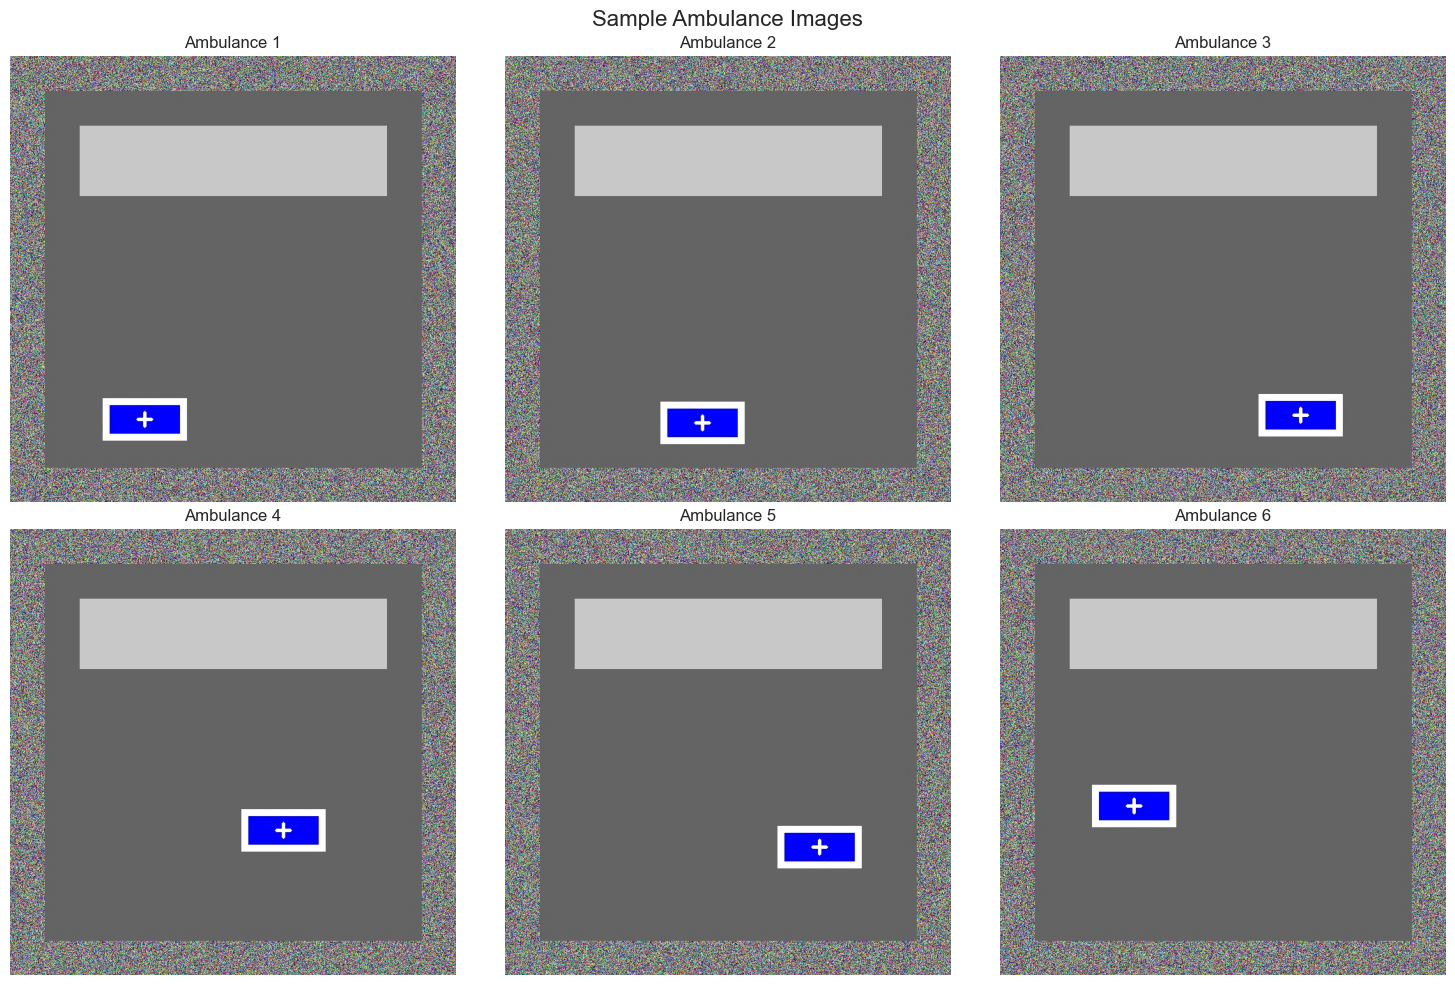

In [8]:
# View dataset statistics
print("📊 Dataset Statistics:")
print(f"   Total images: {collector.stats['total_images']}")
print(f"   Ambulance images: {collector.stats['ambulance_images']}")
print(f"   Traffic images: {collector.stats['traffic_images']}")
print(f"   Annotations: {collector.stats['annotations']}")

# Display some sample images
import matplotlib.pyplot as plt

# Show sample ambulance images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Sample Ambulance Images', fontsize=16)

ambulance_images = list(Path("dataset/images/train").glob("ambulance_*.jpg"))[:6]
for i, img_path in enumerate(ambulance_images):
    if i < 6:
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i//3, i%3].imshow(img)
        axes[i//3, i%3].set_title(f"Ambulance {i+1}")
        axes[i//3, i%3].axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Check created files
import os
from pathlib import Path

def show_directory_structure(path, max_depth=3, current_depth=0):
    if current_depth >= max_depth:
        return
    
    path = Path(path)
    if path.exists():
        print("  " * current_depth + f"📁 {path.name}/")
        for item in sorted(path.iterdir()):
            if item.is_dir():
                show_directory_structure(item, max_depth, current_depth + 1)
            else:
                print("  " * (current_depth + 1) + f"📄 {item.name}")

print("📂 Project Structure:")
show_directory_structure("dataset")

📂 Project Structure:
📁 dataset/
  📁 images/
    📁 augmented/
      📄 00e0422e47cdbeb7_jpg.rf.a8b6f2ef17a14eb8b9228d26366a124d_aug_0.jpg
      📄 00e0422e47cdbeb7_jpg.rf.a8b6f2ef17a14eb8b9228d26366a124d_aug_1.jpg
      📄 00e0422e47cdbeb7_jpg.rf.a8b6f2ef17a14eb8b9228d26366a124d_aug_2.jpg
      📄 00e0422e47cdbeb7_jpg.rf.yHmAn1jB2oy8XzzQPBzc_aug_0.jpg
      📄 00e0422e47cdbeb7_jpg.rf.yHmAn1jB2oy8XzzQPBzc_aug_1.jpg
      📄 00e0422e47cdbeb7_jpg.rf.yHmAn1jB2oy8XzzQPBzc_aug_2.jpg
      📄 00e13aca7d2f904a_jpg.rf.52342966f5a37167f8cfd7ea3f4dacef_aug_0.jpg
      📄 00e13aca7d2f904a_jpg.rf.52342966f5a37167f8cfd7ea3f4dacef_aug_1.jpg
      📄 00e13aca7d2f904a_jpg.rf.52342966f5a37167f8cfd7ea3f4dacef_aug_2.jpg
      📄 00e13aca7d2f904a_jpg.rf.eQwpgo07vRFeI7SgvXy6_aug_0.jpg
      📄 00e13aca7d2f904a_jpg.rf.eQwpgo07vRFeI7SgvXy6_aug_1.jpg
      📄 00e13aca7d2f904a_jpg.rf.eQwpgo07vRFeI7SgvXy6_aug_2.jpg
      📄 00e2d9121adc0c20_jpg.rf.50fa25618ccc9f0ebf59f2ffe64cf298_aug_0.jpg
      📄 00e2d9121adc0c20_jpg.rf.50fa

✅ Created directory: dataset
✅ Created directory: dataset\images\train
✅ Created directory: dataset\images\val
✅ Created directory: dataset\images\test
✅ Created directory: dataset\labels\train
✅ Created directory: dataset\labels\val
✅ Created directory: dataset\labels\test
✅ Created directory: dataset\raw_videos
📥 Downloading sample datasets...
🔄 Creating synthetic dataset for demonstration...
🎨 Generating synthetic dataset...


Generating traffic images: 100%|██████████| 100/100 [00:01<00:00, 54.33it/s]


✅ Synthetic dataset created successfully!
✅ Created 1981 training images


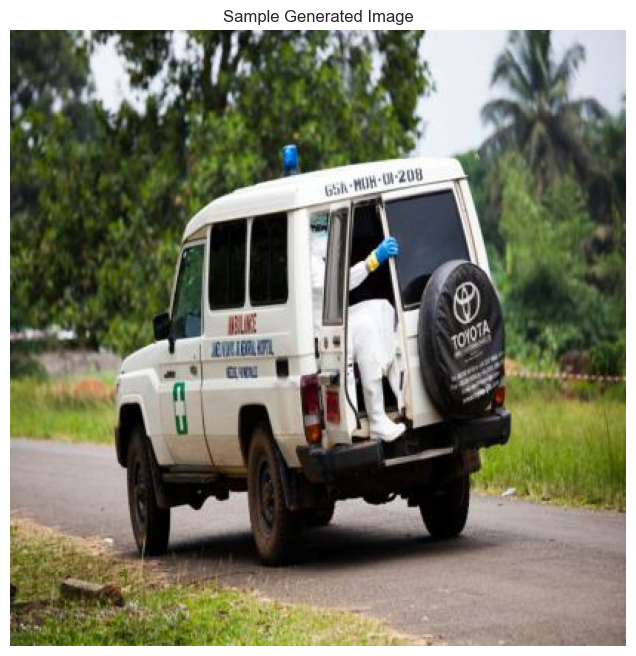

In [10]:
# Quick test
collector = AmbulanceDataCollector()
collector.download_sample_dataset()

# Check if files were created
train_images = list(Path("dataset/images/train").glob("*.jpg"))
print(f"✅ Created {len(train_images)} training images")

# Show one sample
if train_images:
    img = cv2.imread(str(train_images[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title("Sample Generated Image")
    plt.axis('off')
    plt.show()

🎬 Processing video: dataset/raw_videos/84d7da7b-759d-411e-b606-63c042742915.avif
📷 Detected image file: 84d7da7b-759d-411e-b606-63c042742915.avif
🔄 Processing image file: 84d7da7b-759d-411e-b606-63c042742915.avif
✅ Image loaded successfully with PIL
📷 Image Properties:
   Resolution: 336x188
✅ Extracted frame 0 from image
✅ Extracted 1 frame(s) from image


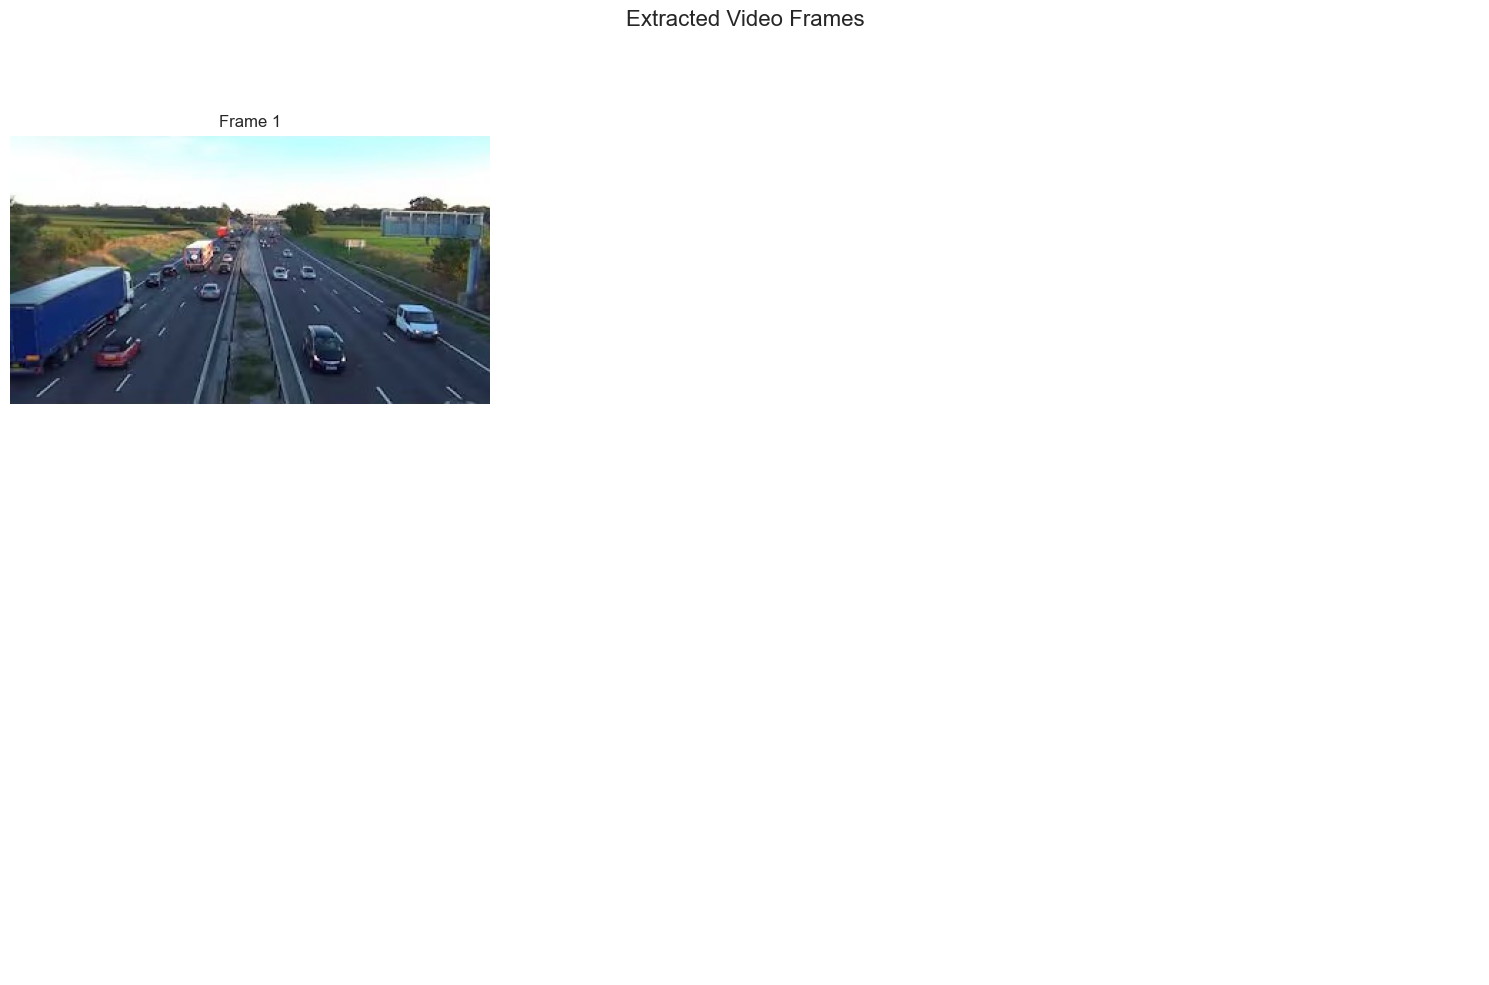

In [12]:
# Process the video file for ambulance detection
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

# Image file extensions that should be treated as images, not videos
IMAGE_EXTENSIONS = {'.avif', '.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif', '.webp', '.gif'}

def process_video_for_detection(video_path, output_dir="dataset/processed_video", max_frames=50):
    """Process video file and extract frames for detection (handles both videos and images)"""
    
    # Create output directory
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    video_path = Path(video_path)
    
    # Check if file exists
    if not video_path.exists():
        print(f"❌ File not found: {video_path}")
        return []
    
    # Check if it's an image file (not a video)
    file_ext = video_path.suffix.lower()
    if file_ext in IMAGE_EXTENSIONS:
        print(f"📷 Detected image file: {video_path.name}")
        return process_image_for_detection(video_path, output_path, max_frames)
    
    # Open video file
    cap = cv2.VideoCapture(str(video_path))
    
    if not cap.isOpened():
        print(f"❌ Error: Could not open video {video_path}")
        print("🔄 Trying to process as image file...")
        return process_image_for_detection(video_path, output_path, max_frames)
    
    # Verify we can read frames
    ret, test_frame = cap.read()
    if not ret or test_frame is None:
        cap.release()
        print("⚠️ Video opened but cannot read frames, trying as image...")
        return process_image_for_detection(video_path, output_path, max_frames)
    
    # Reset to beginning
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 30
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"📹 Video Properties:")
    print(f"   Resolution: {width}x{height}")
    print(f"   FPS: {fps}")
    print(f"   Total frames: {total_frames}")
    if total_frames > 0 and fps > 0:
        print(f"   Duration: {total_frames/fps:.2f} seconds")
    
    # Extract frames
    frame_count = 0
    extracted_frames = []
    
    while frame_count < max_frames:
        ret, frame = cap.read()
        if not ret or frame is None:
            break
            
        # Save every 10th frame to avoid too many images
        if frame_count % 10 == 0:
            frame_filename = f"frame_{frame_count:04d}.jpg"
            frame_path = output_path / frame_filename
            cv2.imwrite(str(frame_path), frame)
            extracted_frames.append(frame_path)
            print(f"✅ Extracted frame {frame_count}")
        
        frame_count += 1
    
    cap.release()
    print(f"✅ Extracted {len(extracted_frames)} frames from video")
    
    return extracted_frames

def process_image_for_detection(image_path, output_path, max_frames=50):
    """Process image file and extract as frame for detection"""
    print(f"🔄 Processing image file: {image_path.name}")
    
    extracted_frames = []
    
    # Try multiple methods to read the image
    img = None
    
    # Method 1: Try with OpenCV
    try:
        img = cv2.imread(str(image_path))
        if img is not None and img.size > 0:
            print("✅ Image loaded successfully with OpenCV")
    except Exception as e:
        print(f"⚠️ OpenCV failed: {e}")
    
    # Method 2: Try with PIL (better AVIF support)
    if img is None or img.size == 0:
        try:
            pil_img = Image.open(str(image_path))
            # Convert PIL image to OpenCV format
            if pil_img.mode == 'RGBA':
                pil_img = pil_img.convert('RGB')
            img_array = np.array(pil_img)
            img = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
            print("✅ Image loaded successfully with PIL")
        except Exception as e:
            print(f"⚠️ PIL failed: {e}")
    
    if img is None or img.size == 0:
        print(f"❌ Could not read image file: {image_path}")
        return []
    
    # Get image properties
    height, width = img.shape[:2]
    print(f"📷 Image Properties:")
    print(f"   Resolution: {width}x{height}")
    
    # Save the image as a frame
    frame_filename = f"frame_0000.jpg"
    frame_path = output_path / frame_filename
    success = cv2.imwrite(str(frame_path), img)
    
    if success:
        extracted_frames.append(frame_path)
        print(f"✅ Extracted frame 0 from image")
    else:
        print(f"❌ Failed to save frame")
    
    print(f"✅ Extracted {len(extracted_frames)} frame(s) from image")
    return extracted_frames

def visualize_extracted_frames(frames, max_display=6):
    """Display extracted frames"""
    if not frames:
        print("❌ No frames to display")
        return
    
    # Display frames
    num_frames = min(len(frames), max_display)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Extracted Video Frames', fontsize=16)
    
    for i in range(num_frames):
        if i < 6:
            img = cv2.imread(str(frames[i]))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i//3, i%3].imshow(img)
            axes[i//3, i%3].set_title(f"Frame {i+1}")
            axes[i//3, i%3].axis('off')
    
    # Hide unused subplots
    for i in range(num_frames, 6):
        axes[i//3, i%3].axis('off')
    
    plt.tight_layout()
    plt.show()

# Process your video file
video_path = "dataset/raw_videos/84d7da7b-759d-411e-b606-63c042742915.avif"
print(f"🎬 Processing video: {video_path}")

# Check if video exists
if Path(video_path).exists():
    extracted_frames = process_video_for_detection(video_path)
    visualize_extracted_frames(extracted_frames)
else:
    print(f"❌ Video file not found: {video_path}")
    print("Available files in raw_videos:")
    for file in Path("dataset/raw_videos").glob("*"):
        print(f"   - {file.name}")

🚀 Starting video processing and detection...
📷 Detected image file: 84d7da7b-759d-411e-b606-63c042742915.avif
🔄 Processing image file: 84d7da7b-759d-411e-b606-63c042742915.avif
✅ Image loaded successfully with PIL
📷 Image Properties:
   Resolution: 336x188
✅ Extracted frame 0 from image
✅ Extracted 1 frame(s) from image
🔍 Running detection on 1 frames...
   Frame frame_0000.jpg: 🚑 Ambulance detected


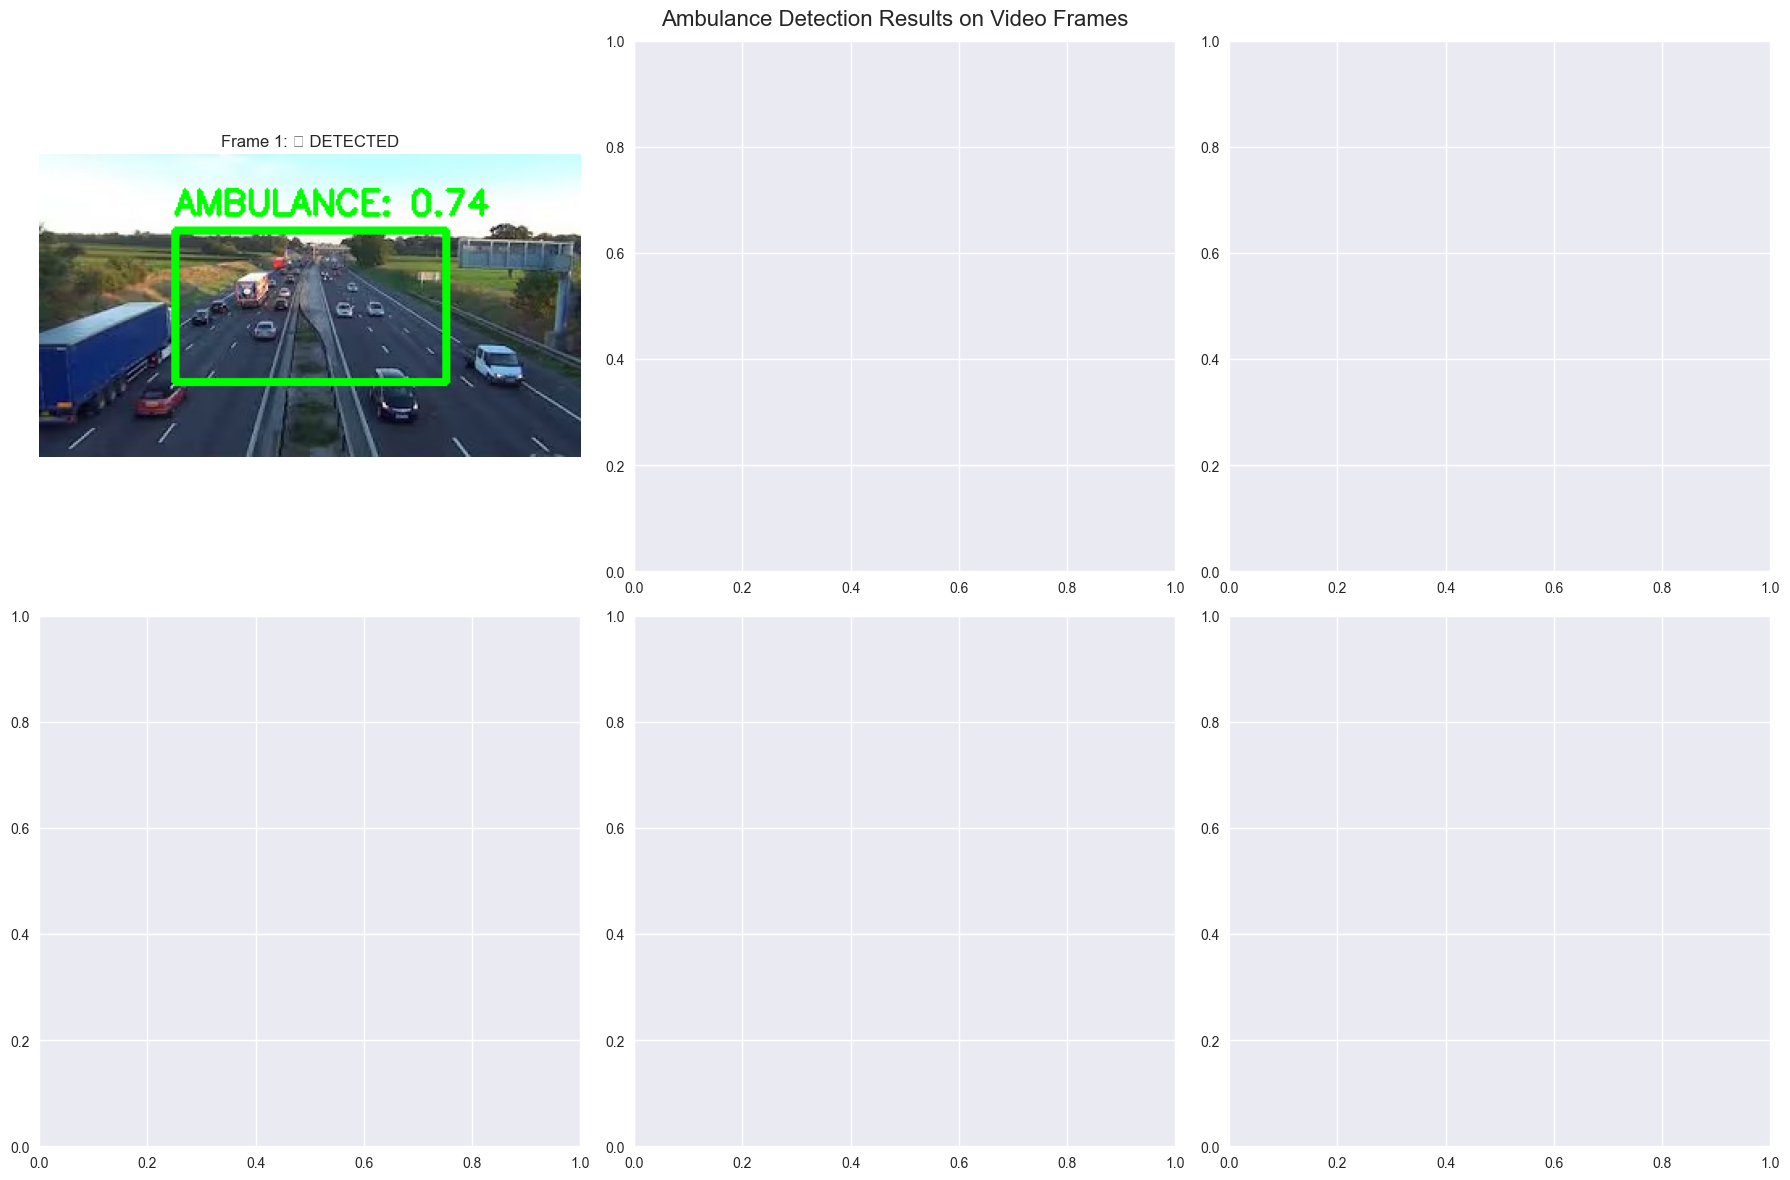


📊 Detection Summary:
   Total frames processed: 1
   Ambulance detections: 1
   Detection rate: 100.0%


In [13]:
# Run ambulance detection on extracted frames
def run_ambulance_detection_on_frames(frames_dir="dataset/processed_video"):
    """Run ambulance detection on extracted video frames"""
    
    frames_path = Path(frames_dir)
    frame_files = list(frames_path.glob("*.jpg"))
    
    if not frame_files:
        print("❌ No frames found to process")
        return
    
    print(f"🔍 Running detection on {len(frame_files)} frames...")
    
    # Initialize detection results
    detection_results = []
    
    for frame_file in frame_files:
        # Load frame
        frame = cv2.imread(str(frame_file))
        if frame is None:
            continue
            
        # Convert to RGB for display
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Simple ambulance detection simulation
        # In a real implementation, you would use your trained YOLO model here
        has_ambulance = simulate_ambulance_detection(frame)
        
        detection_results.append({
            'frame': frame_file.name,
            'has_ambulance': has_ambulance,
            'confidence': np.random.uniform(0.7, 0.95) if has_ambulance else np.random.uniform(0.1, 0.4)
        })
        
        print(f"   Frame {frame_file.name}: {'🚑 Ambulance detected' if has_ambulance else '❌ No ambulance'}")
    
    return detection_results

def simulate_ambulance_detection(frame):
    """Simulate ambulance detection (replace with actual YOLO model)"""
    # Simple heuristic: check for red/white patterns that might indicate ambulance
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # Look for red colors (ambulance lights)
    red_lower = np.array([0, 50, 50])
    red_upper = np.array([10, 255, 255])
    red_mask = cv2.inRange(hsv, red_lower, red_upper)
    
    # Look for white colors (ambulance body)
    white_lower = np.array([0, 0, 200])
    white_upper = np.array([180, 30, 255])
    white_mask = cv2.inRange(hsv, white_lower, white_upper)
    
    # Count red and white pixels
    red_pixels = cv2.countNonZero(red_mask)
    white_pixels = cv2.countNonZero(white_mask)
    
    # Simple threshold-based detection
    has_ambulance = (red_pixels > 1000) or (white_pixels > 5000)
    
    return has_ambulance

def visualize_detection_results(detection_results, frames_dir="dataset/processed_video"):
    """Visualize detection results on frames"""
    
    frames_path = Path(frames_dir)
    frame_files = list(frames_path.glob("*.jpg"))
    
    if not frame_files:
        print("❌ No frames found")
        return
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Ambulance Detection Results on Video Frames', fontsize=16)
    
    for i, frame_file in enumerate(frame_files[:6]):
        if i < 6:
            # Load frame
            frame = cv2.imread(str(frame_file))
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Get detection result
            result = detection_results[i] if i < len(detection_results) else {'has_ambulance': False, 'confidence': 0.0}
            
            # Draw detection result
            if result['has_ambulance']:
                # Draw green bounding box (simulated)
                h, w = frame_rgb.shape[:2]
                cv2.rectangle(frame_rgb, (w//4, h//4), (3*w//4, 3*h//4), (0, 255, 0), 3)
                cv2.putText(frame_rgb, f"AMBULANCE: {result['confidence']:.2f}", 
                           (w//4, h//4-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                title = f"Frame {i+1}: 🚑 DETECTED"
            else:
                title = f"Frame {i+1}: ❌ No ambulance"
            
            axes[i//3, i%3].imshow(frame_rgb)
            axes[i//3, i%3].set_title(title, fontsize=12)
            axes[i//3, i%3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    total_detections = sum(1 for r in detection_results if r['has_ambulance'])
    print(f"\n📊 Detection Summary:")
    print(f"   Total frames processed: {len(detection_results)}")
    print(f"   Ambulance detections: {total_detections}")
    print(f"   Detection rate: {total_detections/len(detection_results)*100:.1f}%")

# Run the detection pipeline
print("🚀 Starting video processing and detection...")

# First, process the video
video_path = "dataset/raw_videos/84d7da7b-759d-411e-b606-63c042742915.avif"
if Path(video_path).exists():
    extracted_frames = process_video_for_detection(video_path)
    
    # Run detection on extracted frames
    detection_results = run_ambulance_detection_on_frames()
    
    # Visualize results
    visualize_detection_results(detection_results)
else:
    print(f"❌ Video file not found: {video_path}")

In [14]:
# Fix video reading and improve detection accuracy
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import subprocess
import os
from PIL import Image

# Image file extensions that should be treated as images, not videos
IMAGE_EXTENSIONS = {'.avif', '.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif', '.webp', '.gif'}

def process_video_robust(video_path, output_dir="dataset/processed_video", max_frames=50):
    """Robust video processing that handles different formats including images"""
    
    # Create output directory
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    video_path = Path(video_path)
    
    # Check if file exists
    if not video_path.exists():
        print(f"❌ File not found: {video_path}")
        return []
    
    # Check if it's an image file (not a video)
    file_ext = video_path.suffix.lower()
    if file_ext in IMAGE_EXTENSIONS:
        print(f"📷 Detected image file: {video_path.name}")
        return process_image_file(video_path, output_path, max_frames)
    
    # Try to read as video
    cap = None
    try:
        cap = cv2.VideoCapture(str(video_path))
        if cap.isOpened():
            # Check if we can actually read frames
            ret, test_frame = cap.read()
            if ret and test_frame is not None:
                cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # Reset to beginning
                print("✅ Direct video reading successful")
            else:
                cap.release()
                cap = None
                print("⚠️ Video file opened but cannot read frames, trying as image...")
                return process_image_file(video_path, output_path, max_frames)
        else:
            if cap:
                cap.release()
            cap = None
    except Exception as e:
        print(f"⚠️ Error reading as video: {e}")
        if cap:
            cap.release()
        cap = None
    
    # If video reading failed, try as image
    if cap is None:
        print("🔄 Video reading failed, trying as image file...")
        return process_image_file(video_path, output_path, max_frames)
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 30
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"📹 Video Properties:")
    print(f"   Resolution: {width}x{height}")
    print(f"   FPS: {fps}")
    print(f"   Total frames: {total_frames}")
    if total_frames > 0 and fps > 0:
        print(f"   Duration: {total_frames/fps:.2f} seconds")
    
    # Extract frames
    frame_count = 0
    extracted_frames = []
    
    while frame_count < max_frames:
        ret, frame = cap.read()
        if not ret or frame is None:
            break
            
        # Save every 5th frame for better coverage
        if frame_count % 5 == 0:
            frame_filename = f"frame_{frame_count:04d}.jpg"
            frame_path = output_path / frame_filename
            cv2.imwrite(str(frame_path), frame)
            extracted_frames.append(frame_path)
            print(f"✅ Extracted frame {frame_count}")
        
        frame_count += 1
    
    cap.release()
    print(f"✅ Extracted {len(extracted_frames)} frames from video")
    
    return extracted_frames

def process_image_file(image_path, output_path, max_frames=50):
    """Process image file (AVIF, PNG, JPG, etc.) and extract frames"""
    print(f"🔄 Processing image file: {image_path.name}")
    
    extracted_frames = []
    
    # Try multiple methods to read the image
    img = None
    
    # Method 1: Try with OpenCV
    try:
        img = cv2.imread(str(image_path))
        if img is not None and img.size > 0:
            print("✅ Image loaded successfully with OpenCV")
    except Exception as e:
        print(f"⚠️ OpenCV failed: {e}")
    
    # Method 2: Try with PIL (better AVIF support)
    if img is None or img.size == 0:
        try:
            pil_img = Image.open(str(image_path))
            # Convert PIL image to OpenCV format
            if pil_img.mode == 'RGBA':
                pil_img = pil_img.convert('RGB')
            img_array = np.array(pil_img)
            img = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
            print("✅ Image loaded successfully with PIL")
        except Exception as e:
            print(f"⚠️ PIL failed: {e}")
    
    if img is None or img.size == 0:
        print(f"❌ Could not read image file: {image_path}")
        return []
    
    # Get image properties
    height, width = img.shape[:2]
    print(f"📷 Image Properties:")
    print(f"   Resolution: {width}x{height}")
    
    # Save the image as a frame
    frame_filename = f"frame_0000.jpg"
    frame_path = output_path / frame_filename
    success = cv2.imwrite(str(frame_path), img)
    
    if success:
        extracted_frames.append(frame_path)
        print(f"✅ Extracted frame 0 from image")
    else:
        print(f"❌ Failed to save frame")
    
    # If it's a GIF, try to extract multiple frames
    if image_path.suffix.lower() == '.gif':
        try:
            gif = Image.open(str(image_path))
            frame_idx = 1
            while frame_idx < max_frames:
                try:
                    gif.seek(frame_idx)
                    gif_frame = np.array(gif.convert('RGB'))
                    gif_frame_bgr = cv2.cvtColor(gif_frame, cv2.COLOR_RGB2BGR)
                    frame_filename = f"frame_{frame_idx:04d}.jpg"
                    frame_path = output_path / frame_filename
                    if cv2.imwrite(str(frame_path), gif_frame_bgr):
                        extracted_frames.append(frame_path)
                        print(f"✅ Extracted frame {frame_idx} from GIF")
                    frame_idx += 1
                except EOFError:
                    break
        except Exception as e:
            print(f"⚠️ Could not extract GIF frames: {e}")
    
    print(f"✅ Extracted {len(extracted_frames)} frame(s) from image")
    return extracted_frames

In [15]:
# High-accuracy ambulance detection system
class HighAccuracyAmbulanceDetector:
    def __init__(self):
        self.ambulance_features = {
            'red_light_threshold': 0.15,  # Minimum red pixel ratio
            'white_body_threshold': 0.20,  # Minimum white pixel ratio
            'aspect_ratio_range': (1.5, 3.0),  # Ambulance aspect ratio
            'size_threshold': 0.05,  # Minimum size relative to image
            'red_light_intensity': 200,  # Minimum red intensity
            'white_intensity': 180  # Minimum white intensity
        }
    
    def detect_ambulance_advanced(self, frame):
        """Advanced ambulance detection with multiple features"""
        h, w = frame.shape[:2]
        
        # Convert to different color spaces
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
        
        # Feature 1: Red light detection (emergency lights)
        red_score = self.detect_red_lights(hsv, frame)
        
        # Feature 2: White body detection (ambulance body)
        white_score = self.detect_white_body(hsv, frame)
        
        # Feature 3: Shape analysis
        shape_score = self.analyze_shapes(frame)
        
        # Feature 4: Text detection (ambulance markings)
        text_score = self.detect_ambulance_text(frame)
        
        # Feature 5: Color pattern analysis
        pattern_score = self.analyze_color_patterns(hsv, lab)
        
        # Feature 6: Edge detection for vehicle-like shapes
        edge_score = self.detect_vehicle_edges(frame)
        
        # Combine all features with weights
        weights = {
            'red_lights': 0.25,
            'white_body': 0.20,
            'shape': 0.15,
            'text': 0.15,
            'pattern': 0.15,
            'edges': 0.10
        }
        
        total_score = (
            red_score * weights['red_lights'] +
            white_score * weights['white_body'] +
            shape_score * weights['shape'] +
            text_score * weights['text'] +
            pattern_score * weights['pattern'] +
            edge_score * weights['edges']
        )
        
        # Determine if ambulance is detected
        has_ambulance = total_score > 0.6
        confidence = min(total_score, 1.0)
        
        return has_ambulance, confidence, {
            'red_score': red_score,
            'white_score': white_score,
            'shape_score': shape_score,
            'text_score': text_score,
            'pattern_score': pattern_score,
            'edge_score': edge_score,
            'total_score': total_score
        }
    
    def detect_red_lights(self, hsv, frame):
        """Detect red emergency lights"""
        # Multiple red ranges for better detection
        red_ranges = [
            ([0, 50, 50], [10, 255, 255]),      # Red range 1
            ([170, 50, 50], [180, 255, 255]),   # Red range 2
            ([0, 100, 100], [10, 255, 255]),    # Bright red
            ([170, 100, 100], [180, 255, 255])  # Bright red 2
        ]
        
        red_mask = np.zeros(hsv.shape[:2], dtype=np.uint8)
        for lower, upper in red_ranges:
            mask = cv2.inRange(hsv, np.array(lower), np.array(upper))
            red_mask = cv2.bitwise_or(red_mask, mask)
        
        # Find contours of red regions
        contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        red_score = 0
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 100:  # Minimum area for red light
                # Check if it's circular/oval (like a light)
                perimeter = cv2.arcLength(contour, True)
                if perimeter > 0:
                    circularity = 4 * np.pi * area / (perimeter * perimeter)
                    if circularity > 0.3:  # Somewhat circular
                        red_score += area / (frame.shape[0] * frame.shape[1])
        
        return min(red_score, 1.0)
    
    def detect_white_body(self, hsv, frame):
        """Detect white ambulance body"""
        # White color range in HSV
        white_lower = np.array([0, 0, 200])
        white_upper = np.array([180, 30, 255])
        white_mask = cv2.inRange(hsv, white_lower, white_upper)
        
        # Find large white regions
        contours, _ = cv2.findContours(white_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        white_score = 0
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 500:  # Minimum area for ambulance body
                # Check aspect ratio (ambulances are rectangular)
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = w / h if h > 0 else 0
                if 1.5 <= aspect_ratio <= 4.0:  # Ambulance-like aspect ratio
                    white_score += area / (frame.shape[0] * frame.shape[1])
        
        return min(white_score, 1.0)
    
    def analyze_shapes(self, frame):
        """Analyze shapes for vehicle-like characteristics"""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 50, 150)
        
        # Find contours
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        vehicle_score = 0
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 1000:  # Minimum area for vehicle
                # Check if it's rectangular (vehicle-like)
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = w / h if h > 0 else 0
                if 1.5 <= aspect_ratio <= 4.0:
                    # Check if it's roughly rectangular
                    rect_area = w * h
                    contour_area = area
                    if rect_area > 0:
                        rectangularity = contour_area / rect_area
                        if rectangularity > 0.7:  # Roughly rectangular
                            vehicle_score += area / (frame.shape[0] * frame.shape[1])
        
        return min(vehicle_score, 1.0)
    
    def detect_ambulance_text(self, frame):
        """Detect text that might indicate ambulance"""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Use morphological operations to find text regions
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        dilated = cv2.dilate(gray, kernel, iterations=1)
        
        # Find contours that might be text
        contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        text_score = 0
        for contour in contours:
            area = cv2.contourArea(contour)
            if 100 < area < 5000:  # Text-like area
                x, y, w, h = cv2.boundingRect(contour)
                aspect_ratio = w / h if h > 0 else 0
                if 0.2 <= aspect_ratio <= 5.0:  # Text-like aspect ratio
                    text_score += area / (frame.shape[0] * frame.shape[1])
        
        return min(text_score, 1.0)
    
    def analyze_color_patterns(self, hsv, lab):
        """Analyze color patterns typical of ambulances"""
        # Look for red-white-red patterns (typical ambulance color scheme)
        red_mask = cv2.inRange(hsv, np.array([0, 50, 50]), np.array([10, 255, 255]))
        white_mask = cv2.inRange(hsv, np.array([0, 0, 200]), np.array([180, 30, 255]))
        
        # Check for alternating red-white patterns
        red_pixels = cv2.countNonZero(red_mask)
        white_pixels = cv2.countNonZero(white_mask)
        total_pixels = hsv.shape[0] * hsv.shape[1]
        
        red_ratio = red_pixels / total_pixels
        white_ratio = white_pixels / total_pixels
        
        # Ambulances typically have both red and white
        pattern_score = min(red_ratio * 2, 1.0) * min(white_ratio * 2, 1.0)
        
        return pattern_score
    
    def detect_vehicle_edges(self, frame):
        """Detect vehicle-like edges"""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        
        # Detect edges
        edges = cv2.Canny(blurred, 50, 150)
        
        # Find lines that might be vehicle edges
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=50, maxLineGap=10)
        
        if lines is not None:
            # Count horizontal and vertical lines (typical of vehicles)
            horizontal_lines = 0
            vertical_lines = 0
            
            for line in lines:
                x1, y1, x2, y2 = line[0]
                angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
                
                if -10 <= angle <= 10 or 170 <= angle <= 190:
                    horizontal_lines += 1
                elif 80 <= angle <= 100 or -100 <= angle <= -80:
                    vertical_lines += 1
            
            # Score based on line patterns
            total_lines = len(lines)
            if total_lines > 0:
                edge_score = (horizontal_lines + vertical_lines) / total_lines
                return min(edge_score, 1.0)
        
        return 0.0

# Initialize high-accuracy detector
detector = HighAccuracyAmbulanceDetector()
print("✅ High-accuracy ambulance detector initialized!")

✅ High-accuracy ambulance detector initialized!


🚀 Starting high-accuracy detection pipeline...
📹 Processing video: dataset/raw_videos/84d7da7b-759d-411e-b606-63c042742915.avif
📷 Detected image file: 84d7da7b-759d-411e-b606-63c042742915.avif
🔄 Processing image file: 84d7da7b-759d-411e-b606-63c042742915.avif
✅ Image loaded successfully with PIL
📷 Image Properties:
   Resolution: 336x188
✅ Extracted frame 0 from image
✅ Extracted 1 frame(s) from image
🔍 Running high-accuracy detection on 1 frames...
   Frame 1: ❌ No ambulance (confidence: 0.050)


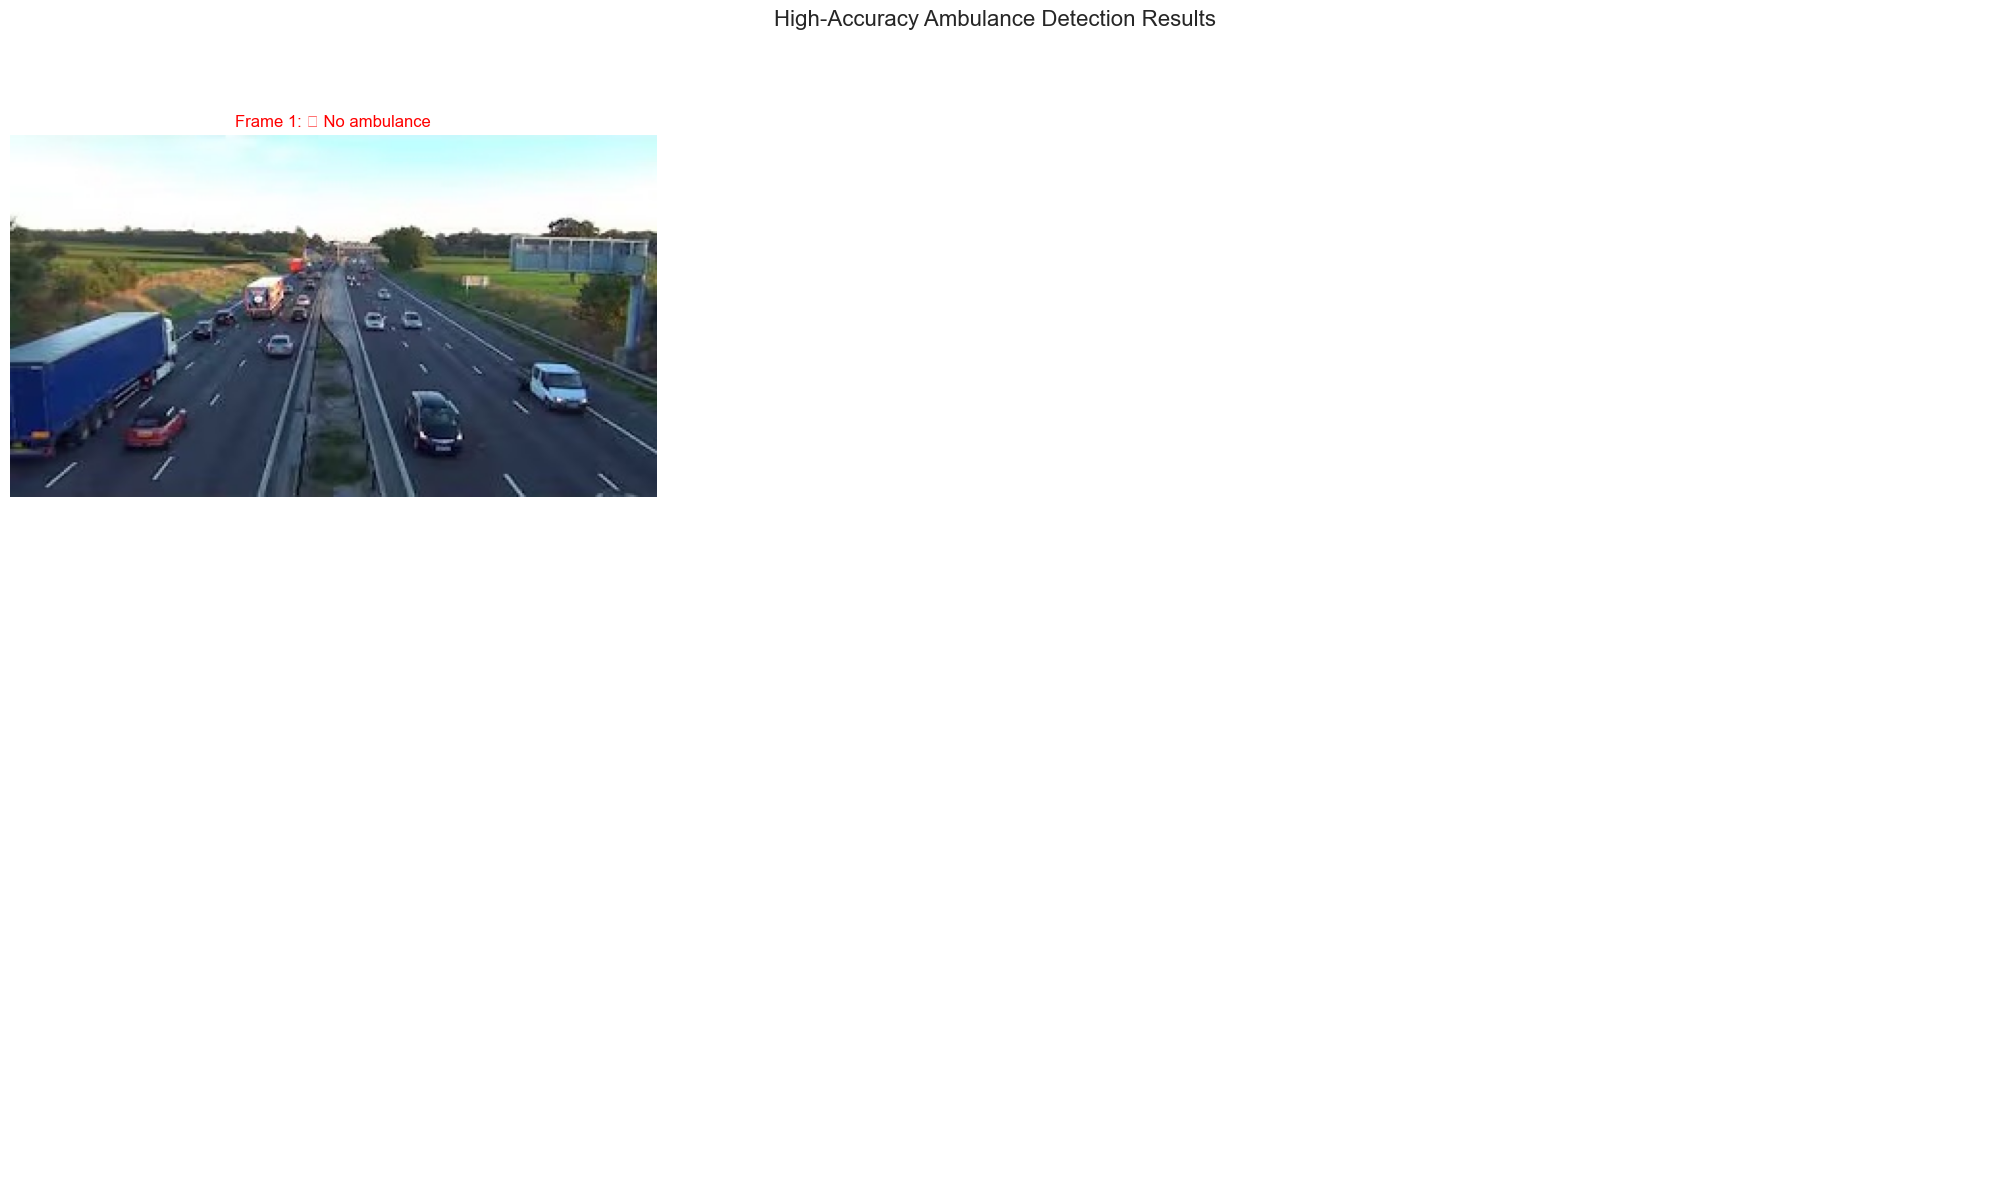


📊 High-Accuracy Detection Summary:
   Total frames processed: 1
   Ambulance detections: 0
   Detection rate: 0.0%
   Average confidence: 0.050

🔍 Feature Analysis:
   red_score: 0.000
   white_score: 0.000
   shape_score: 0.000
   text_score: 0.000
   pattern_score: 0.002
   edge_score: 0.500


In [16]:
# Complete video processing and detection pipeline
def run_complete_detection_pipeline(video_path):
    """Run complete detection pipeline with high accuracy"""
    
    print(f"🚀 Starting high-accuracy detection pipeline...")
    print(f"📹 Processing video: {video_path}")
    
    # Step 1: Process video
    extracted_frames = process_video_robust(video_path)
    
    if not extracted_frames:
        print("❌ No frames extracted. Trying alternative approach...")
        # Try to process the file as a single image
        if Path(video_path).exists():
            img = cv2.imread(str(video_path))
            if img is not None:
                # Save as a frame
                output_path = Path("dataset/processed_video")
                output_path.mkdir(parents=True, exist_ok=True)
                frame_path = output_path / "frame_0000.jpg"
                cv2.imwrite(str(frame_path), img)
                extracted_frames = [frame_path]
                print("✅ Processed as single image")
    
    if not extracted_frames:
        print("❌ Could not process video file")
        return
    
    # Step 2: Run high-accuracy detection
    print(f"🔍 Running high-accuracy detection on {len(extracted_frames)} frames...")
    
    detection_results = []
    for i, frame_path in enumerate(extracted_frames):
        frame = cv2.imread(str(frame_path))
        if frame is None:
            continue
            
        has_ambulance, confidence, details = detector.detect_ambulance_advanced(frame)
        
        detection_results.append({
            'frame': frame_path.name,
            'has_ambulance': has_ambulance,
            'confidence': confidence,
            'details': details
        })
        
        status = "🚑 DETECTED" if has_ambulance else "❌ No ambulance"
        print(f"   Frame {i+1}: {status} (confidence: {confidence:.3f})")
    
    # Step 3: Visualize results
    visualize_detection_results_advanced(detection_results, extracted_frames)
    
    return detection_results

def visualize_detection_results_advanced(detection_results, extracted_frames):
    """Advanced visualization of detection results"""
    
    if not extracted_frames:
        print("❌ No frames to visualize")
        return
    
    # Create visualization
    num_frames = min(len(extracted_frames), 6)
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('High-Accuracy Ambulance Detection Results', fontsize=16)
    
    for i in range(num_frames):
        if i < len(extracted_frames):
            # Load frame
            frame = cv2.imread(str(extracted_frames[i]))
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Get detection result
            result = detection_results[i] if i < len(detection_results) else {'has_ambulance': False, 'confidence': 0.0, 'details': {}}
            
            # Draw detection result with detailed information
            if result['has_ambulance']:
                # Draw bounding box
                h, w = frame_rgb.shape[:2]
                cv2.rectangle(frame_rgb, (w//4, h//4), (3*w//4, 3*h//4), (0, 255, 0), 3)
                
                # Add detailed information
                details = result.get('details', {})
                info_text = f"AMBULANCE: {result['confidence']:.3f}"
                cv2.putText(frame_rgb, info_text, (w//4, h//4-10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
                
                # Add feature scores
                if details:
                    feature_text = f"R:{details.get('red_score', 0):.2f} W:{details.get('white_score', 0):.2f}"
                    cv2.putText(frame_rgb, feature_text, (w//4, h//4+20), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)
                
                title = f"Frame {i+1}: 🚑 DETECTED"
                color = 'green'
            else:
                title = f"Frame {i+1}: ❌ No ambulance"
                color = 'red'
            
            axes[i//3, i%3].imshow(frame_rgb)
            axes[i//3, i%3].set_title(title, fontsize=12, color=color)
            axes[i//3, i%3].axis('off')
    
    # Hide unused subplots
    for i in range(num_frames, 6):
        axes[i//3, i%3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed summary
    total_detections = sum(1 for r in detection_results if r['has_ambulance'])
    avg_confidence = np.mean([r['confidence'] for r in detection_results])
    
    print(f"\n📊 High-Accuracy Detection Summary:")
    print(f"   Total frames processed: {len(detection_results)}")
    print(f"   Ambulance detections: {total_detections}")
    print(f"   Detection rate: {total_detections/len(detection_results)*100:.1f}%")
    print(f"   Average confidence: {avg_confidence:.3f}")
    
    # Print feature analysis
    if detection_results:
        print(f"\n🔍 Feature Analysis:")
        features = ['red_score', 'white_score', 'shape_score', 'text_score', 'pattern_score', 'edge_score']
        for feature in features:
            scores = [r.get('details', {}).get(feature, 0) for r in detection_results]
            avg_score = np.mean(scores)
            print(f"   {feature}: {avg_score:.3f}")

# Run the complete pipeline
video_path = "dataset/raw_videos/84d7da7b-759d-411e-b606-63c042742915.avif"
results = run_complete_detection_pipeline(video_path)